# Bulk Trendanalyse

_D.A. Brakenhoff, Artesia, 2025_

---

Dit notebook bevat een voorbeeld van de teopassing van de `krw_trendanalyse` op
een set aan tijdreeksen van Provincie Zeeland.

In [8]:
import pastas as ps
import pastastore as pst
import numpy as np
from tqdm.auto import tqdm
import krw_trendanalyse as krw

ps.logger.setLevel("ERROR")

We beginnen vanaf een PastaStore waarin tijdreeksmodellen zijn gemaakt voor een set 
peilbuizen van Provincie Zeeland.

In [9]:
name = "krw_zeeland"
pastastore_path = "../../_projects/tra/pastas_db"
conn = pst.PasConnector(name=name, path=pastastore_path)
pstore = pst.PastaStore(conn)
print(pstore)

PasConnector: library 'oseries' already exists. Linking to existing directory: '/home/david/github/krw_trendanalyse/_projects/tra/pastas_db/krw_zeeland/oseries'
PasConnector: library 'stresses' already exists. Linking to existing directory: '/home/david/github/krw_trendanalyse/_projects/tra/pastas_db/krw_zeeland/stresses'
PasConnector: library 'models' already exists. Linking to existing directory: '/home/david/github/krw_trendanalyse/_projects/tra/pastas_db/krw_zeeland/models'
PasConnector: library 'oseries_models' already exists. Linking to existing directory: '/home/david/github/krw_trendanalyse/_projects/tra/pastas_db/krw_zeeland/oseries_models'
<PastaStore> krw_zeeland: 
 - <PasConnector> 'krw_zeeland': 1714 oseries, 36 stresses, 415 models


We kiezen hier een van de KRW grondwaterlichamen om de analyse voor te doen.

In [10]:
gwlichaam = "Zout grondwater in ondiepe zandlagen"
# gwlichaam = "Zoet grondwater in kreekgebieden"
# gwlichaam = "Zoet grondwater in duingebieden"
# gwlichaam = "Grondwater in diepe zandlagen"
# gwlichaam = "Zoet grondwater in dekzand"

En de periode(s) waarvoor we de trendanalyse willen berekenen. 

In [ ]:
periods = [
    ("2000", "2005"),
    # ("2006", "2011"),
    # ("2012", "2017"),
    ("2018", "2023"),
]

Uitvoeren trendanalyse voor de verschillende methodes.

In [12]:
# maak lijsten om resultatne op te slaan
trends_A = []
trends_B = []
trends_C = []


for oname, models in tqdm(pstore.oseries_models.items(), desc="Compute trends"):
    if not pstore.oseries.loc[oname, "krw_buis"]:
        continue
    if pstore.oseries.loc[oname, "grondwaterlichaam"] != gwlichaam:
        continue

    trends_A.append(krw.mean_per_period(pstore.get_oseries(oname), periods))

    for mlnam in models:
        ml = pstore.models[mlnam]
        if not mlnam.endswith("_vm"):
            trends_B.append(
                krw.model_residual_period_stats(ml, periods, add_contributions=["step"])
            )
        else:
            trends_C.append(
                krw.model_residual_period_stats(
                    ml, periods, add_contributions=["step", "vmeer"]
                )
            )

Compute trends:   0%|          | 0/348 [00:00<?, ?it/s]

Aggregatie van de resultaten kan met `krw.aggregate_trends()`.

In [13]:
agg_A = krw.aggregate_trends(trends_A)
agg_B = krw.aggregate_trends(trends_B)
agg_C = krw.aggregate_trends(trends_C)

Plotten resultaten in histogrammen, inclusief geaggregeerd gemiddelde.

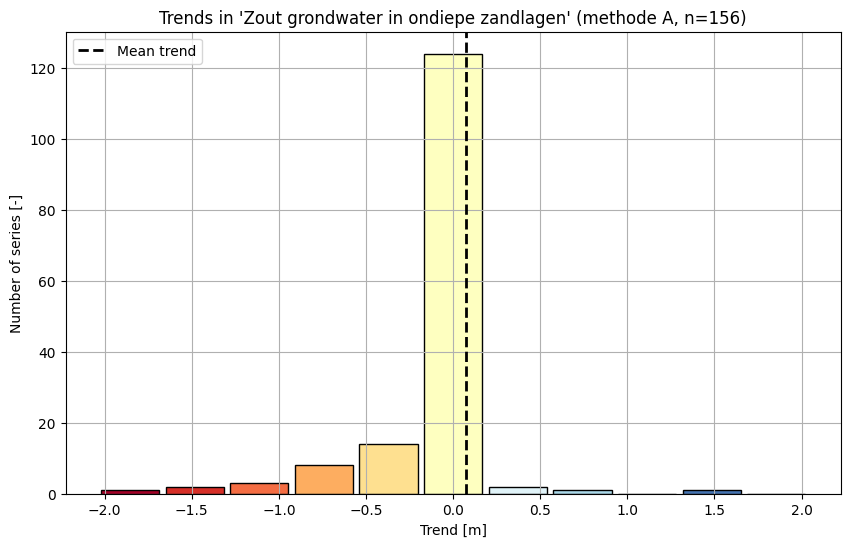

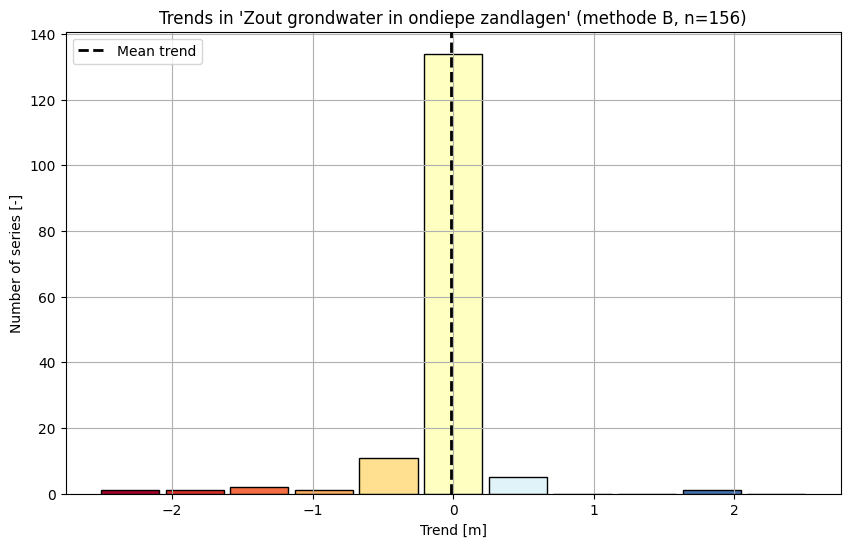

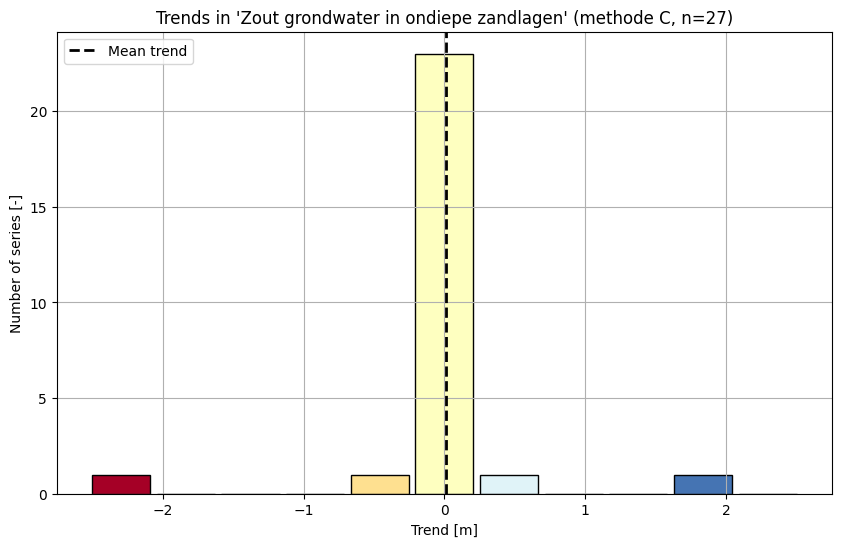

In [ ]:
bins = 11

for method, trends, agg in zip(
    ["A", "B", "C"], [trends_A, trends_B, trends_C], [agg_A, agg_B, agg_C]
):
    ax = krw.plots.histogram(
        trends, method, bins, title=f"Trends in '{gwlichaam}' ", figsize=(5, 4)
    )
    ax.axvline(agg.loc[1, "Δagg_mean"], color="k", ls="--", lw=2.0, label="Mean trend")
    ax.legend(loc="upper left", frameon=True, ncol=2)

Meer ingezoomd rondom de 0.

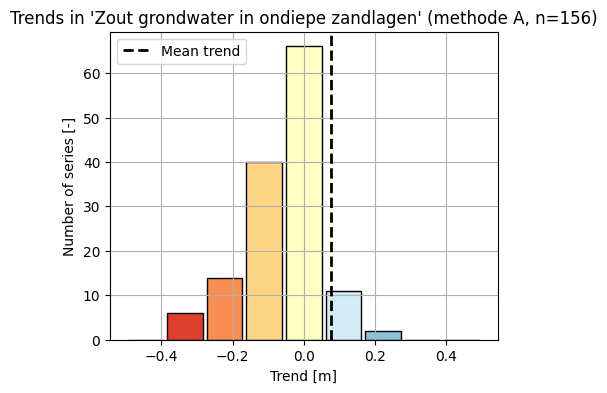

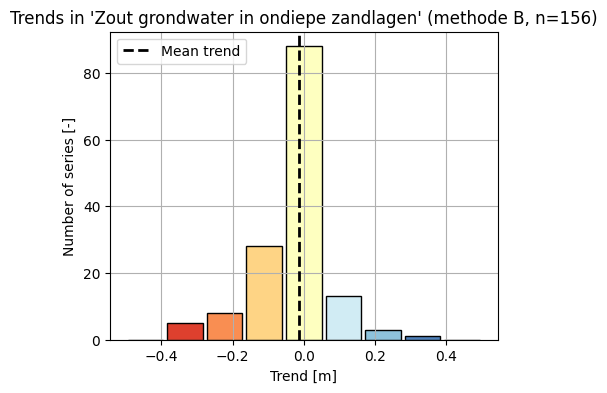

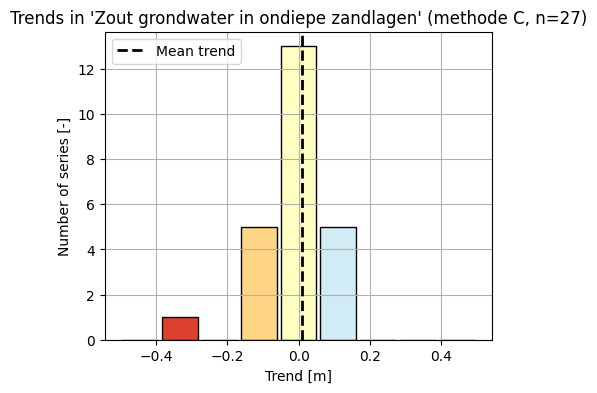

In [23]:
bins = np.linspace(-0.5, 0.5, 10)

for method, trends, agg in zip(
    ["A", "B", "C"], [trends_A, trends_B, trends_C], [agg_A, agg_B, agg_C]
):
    ax = krw.plots.histogram(
        trends, method, bins, title=f"Trends in '{gwlichaam}' ", figsize=(5, 4)
    )
    ax.axvline(agg.loc[1, "Δagg_mean"], color="k", ls="--", lw=2.0, label="Mean trend")
    ax.legend(loc="upper left", frameon=True, ncol=2)

Plotten resultaten trends op kaart.

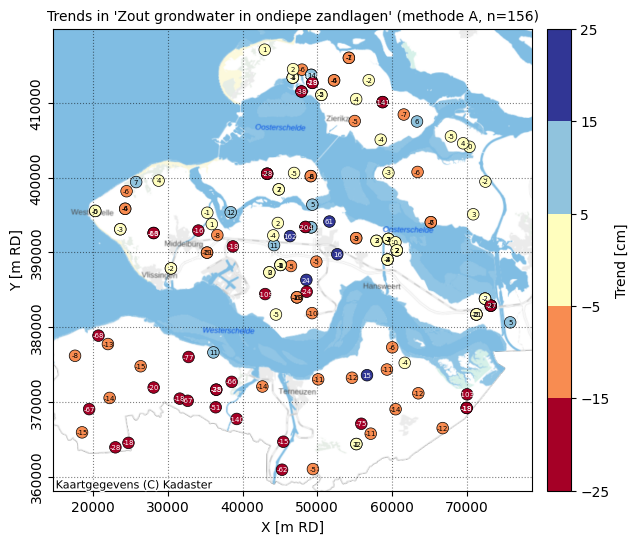

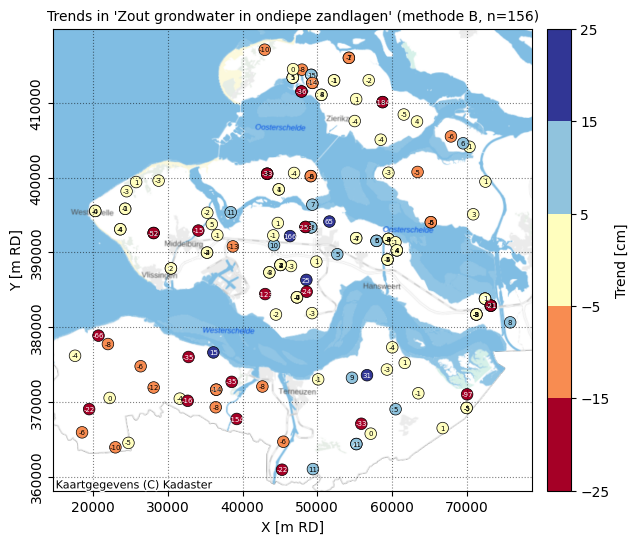

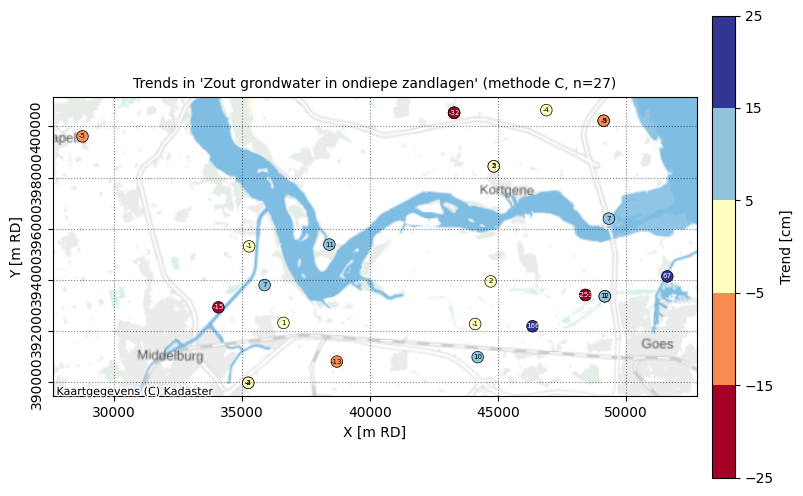

In [15]:
for method, trends in zip(["A", "B", "C"], [trends_A, trends_B, trends_C]):
    location_names = [tr_i.index.name.replace("_vm", "") for tr_i in trends]
    df = pstore.oseries.loc[location_names].copy()
    bins = np.arange(-25, 25 + 1e-5, 10)

    ax = krw.plots.map_trends(
        df.x.values,
        df.y.values,
        trends,
        bins,
        method=method,
        title=f"Trends in '{gwlichaam}'",
    )
    pstore.maps.add_background_map(ax, map_provider="nlmaps.water")